## STFT

開始處理UOEMD-VAFCVS數據集...
處理恆速條件: ['1_0', '1_1', '2_0', '2_1', '3_0', '3_1', '4_0', '4_1', '5_0', '5_1', '6_0', '6_1', '7_0', '7_1', '8_0', '8_1']
生成故障類型比較圖...


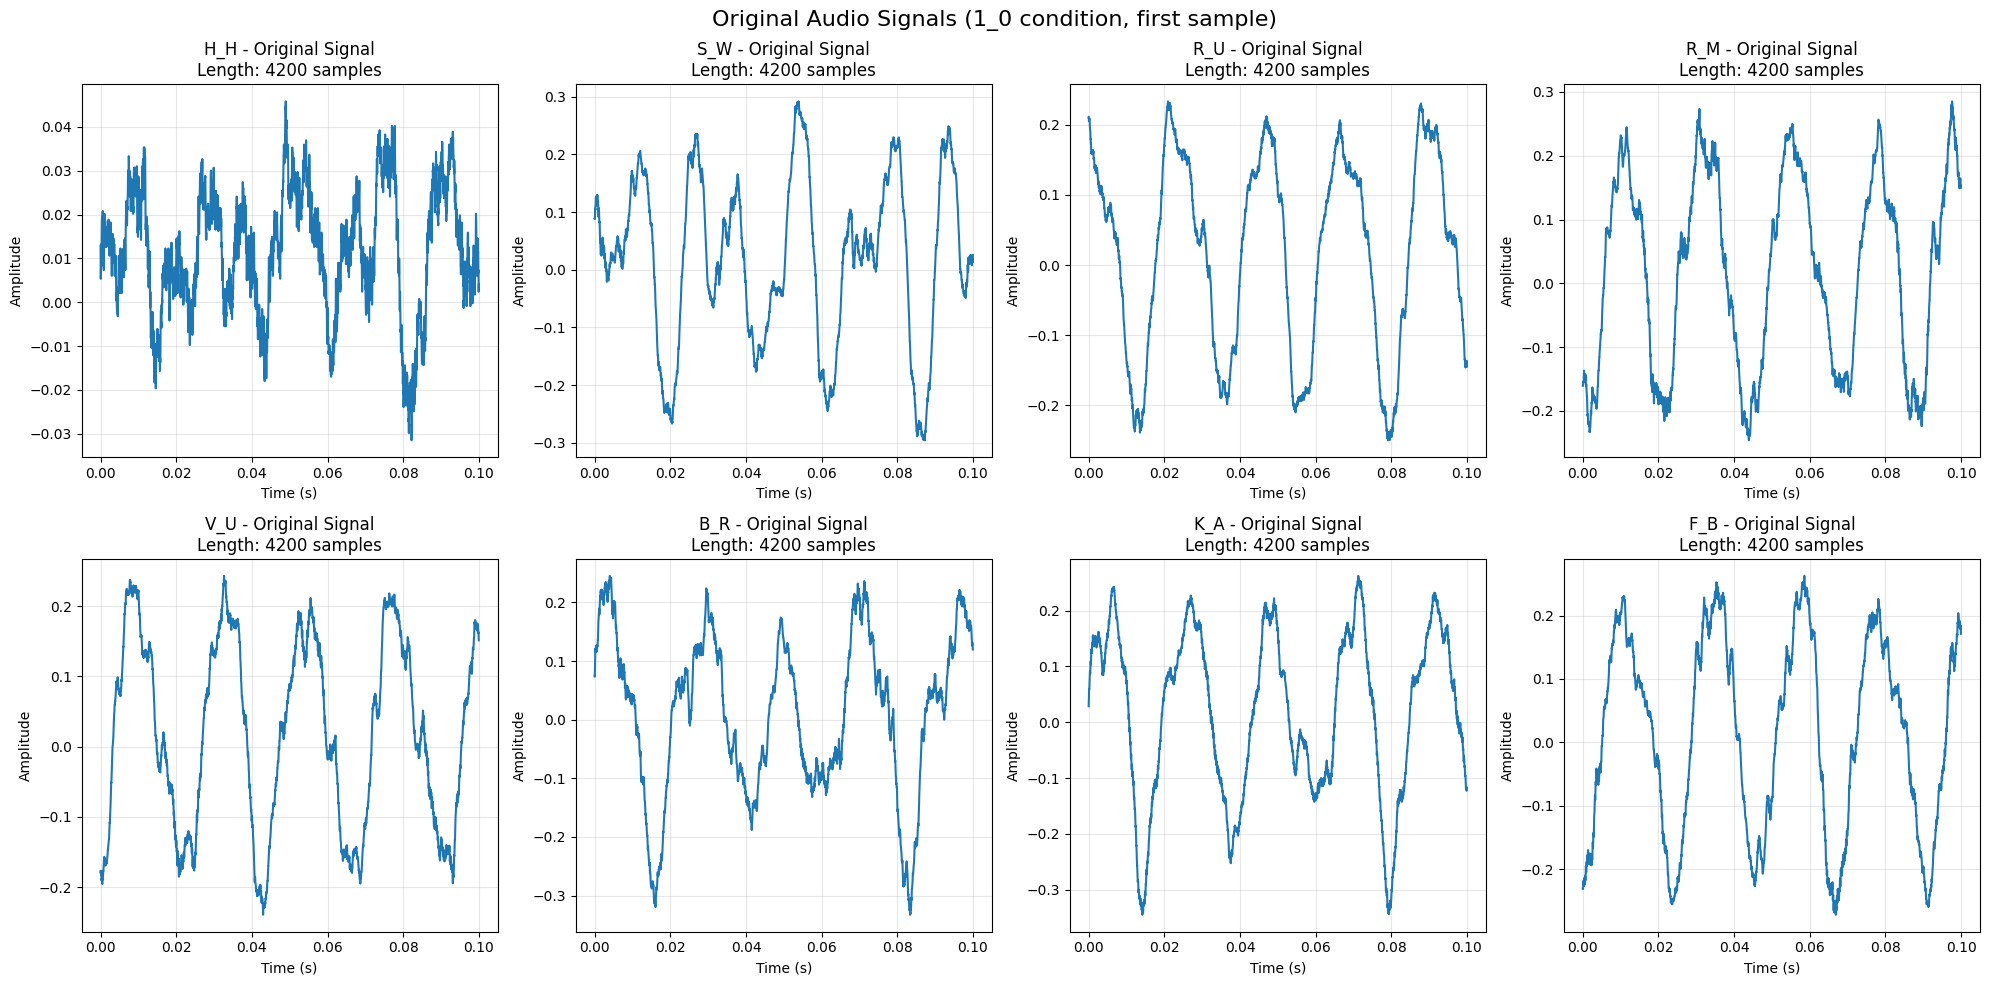

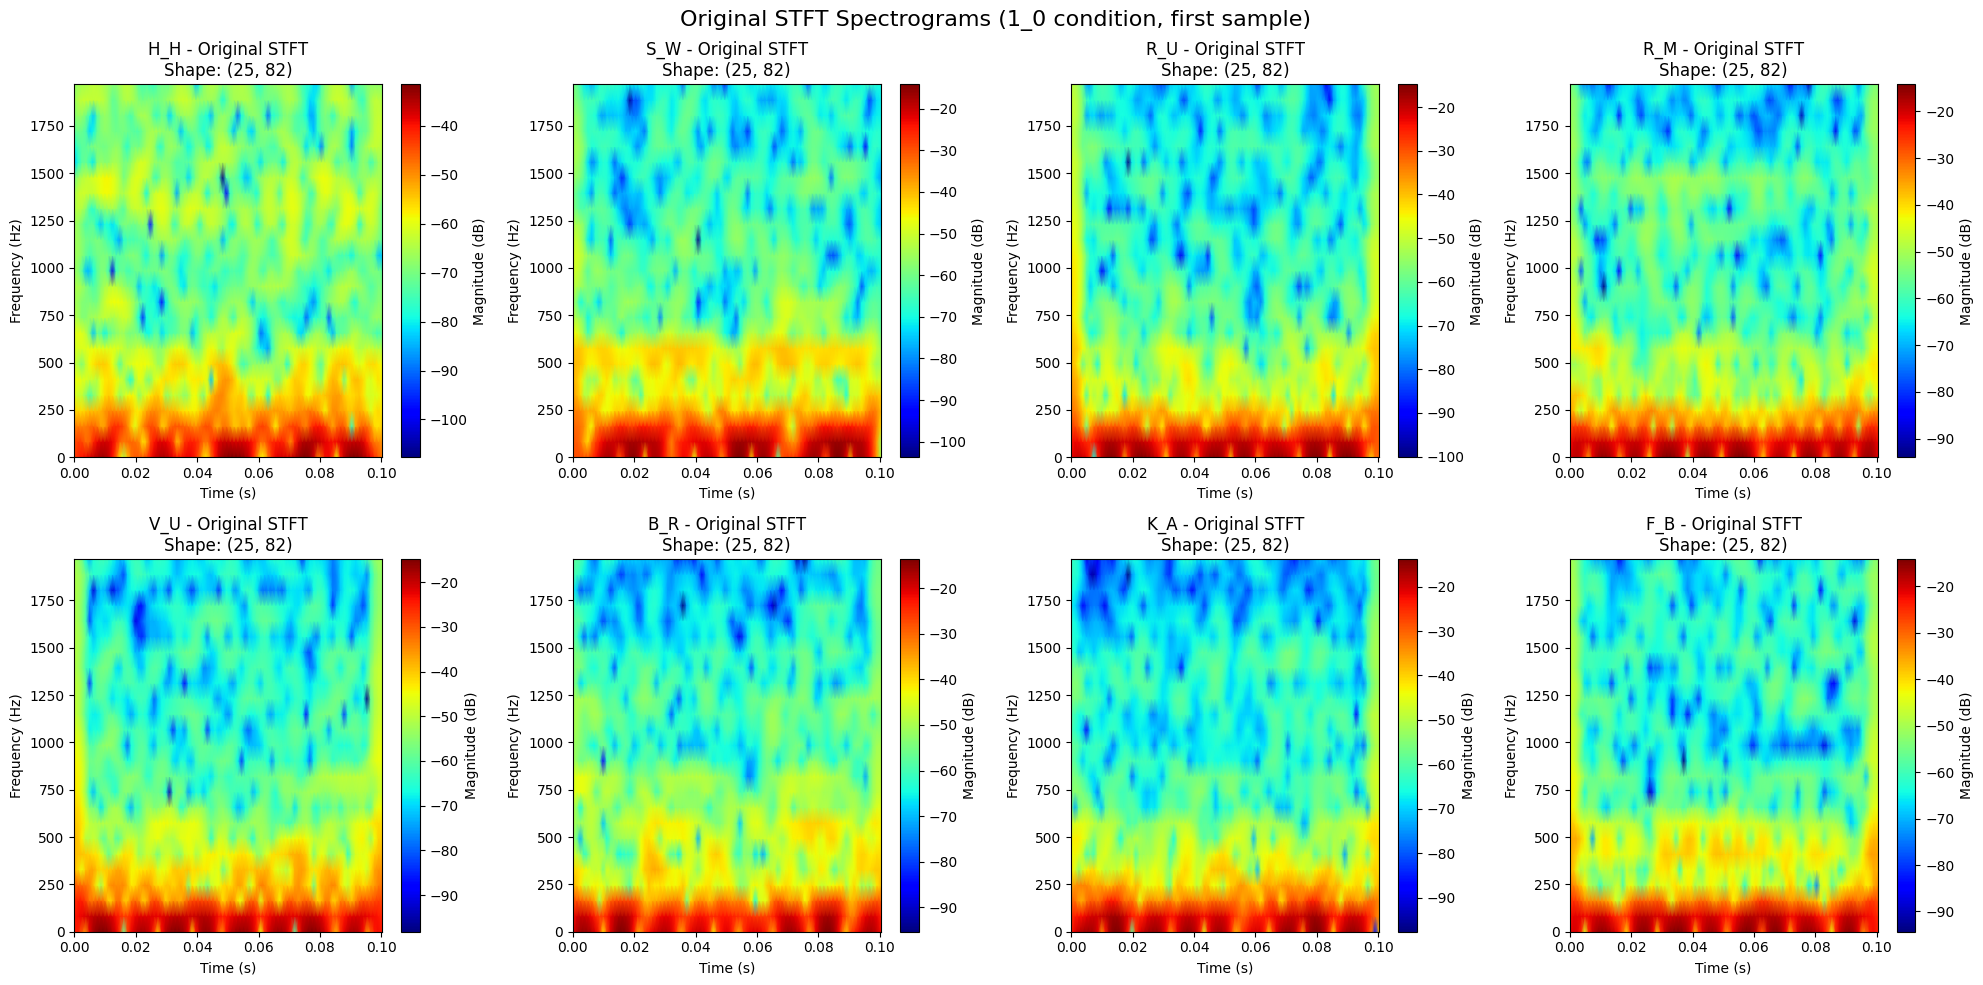

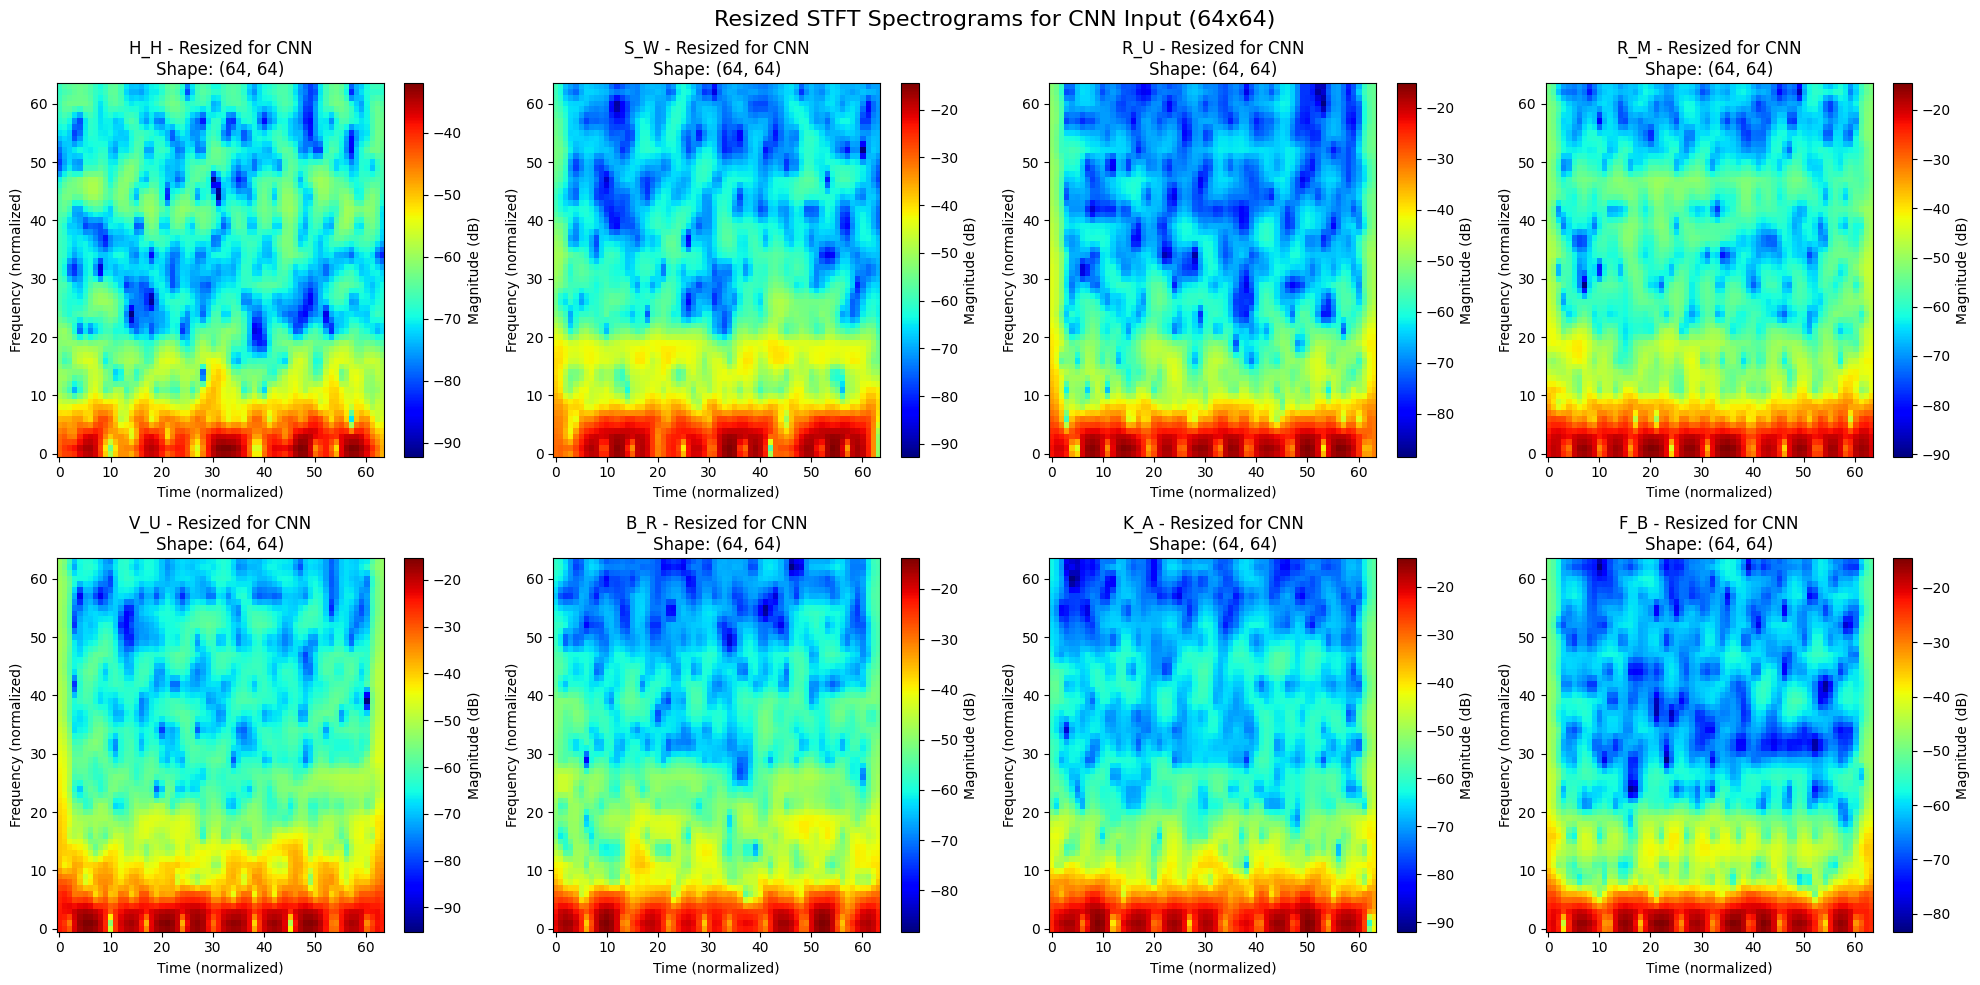

創建二元分類數據集...
處理 /Users/zongyan/Desktop/EMTRC/sound/UOEMD_VAFCVS/2_CSV_Data_Files/H_H_1_0.csv: 總長度 420000, 每個sample長度 4200
處理 /Users/zongyan/Desktop/EMTRC/sound/UOEMD_VAFCVS/2_CSV_Data_Files/H_H_1_1.csv: 總長度 420000, 每個sample長度 4200
處理 /Users/zongyan/Desktop/EMTRC/sound/UOEMD_VAFCVS/2_CSV_Data_Files/H_H_2_0.csv: 總長度 420000, 每個sample長度 4200
處理 /Users/zongyan/Desktop/EMTRC/sound/UOEMD_VAFCVS/2_CSV_Data_Files/H_H_2_1.csv: 總長度 420000, 每個sample長度 4200
處理 /Users/zongyan/Desktop/EMTRC/sound/UOEMD_VAFCVS/2_CSV_Data_Files/H_H_3_0.csv: 總長度 420000, 每個sample長度 4200
處理 /Users/zongyan/Desktop/EMTRC/sound/UOEMD_VAFCVS/2_CSV_Data_Files/H_H_3_1.csv: 總長度 420000, 每個sample長度 4200
處理 /Users/zongyan/Desktop/EMTRC/sound/UOEMD_VAFCVS/2_CSV_Data_Files/H_H_4_0.csv: 總長度 420000, 每個sample長度 4200
處理 /Users/zongyan/Desktop/EMTRC/sound/UOEMD_VAFCVS/2_CSV_Data_Files/H_H_4_1.csv: 總長度 420000, 每個sample長度 4200
處理 /Users/zongyan/Desktop/EMTRC/sound/UOEMD_VAFCVS/2_CSV_Data_Files/H_H_5_0.csv: 總長度 420000, 每個sample長度 4200
處理 /Us

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import pandas as pd
from skimage.transform import resize
import os
from sklearn.model_selection import train_test_split

# 設定參數
fs = 42000  # 採樣頻率 42kHz
window_size = 512
overlap = 460
window = signal.windows.hann(window_size)

# 定義恆速運行條件 (1-0 到 8-1)
constant_speed_conditions = ['1_0', '1_1', '2_0', '2_1', '3_0', '3_1', '4_0', '4_1', '5_0', '5_1', '6_0', '6_1', '7_0', '7_1', '8_0', '8_1']

# 定義故障類型
fault_types = ['H_H', 'S_W', 'R_U', 'R_M', 'V_U', 'B_R', 'K_A', 'F_B']

def load_and_process_data(fault_type, conditions, samples_per_condition=100):
    """
    載入並處理指定故障類型和運行條件的數據
    """
    all_spectrograms = []
    all_labels = []
    
    for condition in conditions:
        file_name = f"/Users/zongyan/Desktop/EMTRC/sound/UOEMD_VAFCVS/2_CSV_Data_Files/{fault_type}_{condition}.csv"
        
        try:
            # 讀取數據
            data = pd.read_csv(file_name)
            acoustic_signal = data.iloc[:, 1].values  # 第二列是聲音數據
            
            # 計算每個sample的長度
            total_length = len(acoustic_signal)
            sample_length = total_length // samples_per_condition
            
            print(f"處理 {file_name}: 總長度 {total_length}, 每個sample長度 {sample_length}")
            
            # 切割成100個samples
            for i in range(samples_per_condition):
                start_idx = i * sample_length
                end_idx = (i + 1) * sample_length
                sample = acoustic_signal[start_idx:end_idx]
                
                # 計算STFT
                f, t, Zxx = signal.stft(sample, fs=fs, window=window, 
                                      nperseg=window_size, noverlap=overlap, 
                                      nfft=window_size, return_onesided=True)
                
                spectrogram = np.abs(Zxx)
                spectrogram_db = 20 * np.log10(spectrogram + 1e-10)
                
                # 限制頻率範圍到2000Hz
                freq_limit = 2000
                freq_mask = f <= freq_limit
                limited_spectrogram = spectrogram_db[freq_mask, :]
                limited_f = f[freq_mask]
                
                # 調整大小以符合CNN輸入要求 (64x64)
                resized_spectrogram = resize(limited_spectrogram, (64, 64), anti_aliasing=True)
                
                all_spectrograms.append(resized_spectrogram)
                all_labels.append(fault_type)
                
        except FileNotFoundError:
            print(f"警告：找不到檔案 {file_name}")
            continue
    
    return np.array(all_spectrograms), np.array(all_labels)

def load_single_sample_for_visualization(fault_type, condition='1_0', sample_index=0):
    """
    載入單個樣本用於視覺化，返回原始STFT和調整大小後的STFT
    """
    file_name = f"/Users/zongyan/Desktop/EMTRC/sound/UOEMD_VAFCVS/2_CSV_Data_Files/{fault_type}_{condition}.csv"
    
    try:
        # 讀取數據
        data = pd.read_csv(file_name)
        acoustic_signal = data.iloc[:, 1].values
        
        # 計算樣本長度
        total_length = len(acoustic_signal)
        sample_length = total_length // 100  # 假設切成100個樣本
        
        # 取指定的樣本
        start_idx = sample_index * sample_length
        end_idx = (sample_index + 1) * sample_length
        sample = acoustic_signal[start_idx:end_idx]
        
        # 計算STFT
        f, t, Zxx = signal.stft(sample, fs=fs, window=window, 
                              nperseg=window_size, noverlap=overlap, 
                              nfft=window_size, return_onesided=True)
        
        spectrogram = np.abs(Zxx)
        spectrogram_db = 20 * np.log10(spectrogram + 1e-10)
        
        # 限制頻率範圍到2000Hz
        freq_limit = 2000
        freq_mask = f <= freq_limit
        limited_spectrogram = spectrogram_db[freq_mask, :]
        limited_f = f[freq_mask]
        
        # 調整大小版本
        resized_spectrogram = resize(limited_spectrogram, (64, 64), anti_aliasing=True)
        
        return limited_spectrogram, resized_spectrogram, limited_f, t
        
    except FileNotFoundError:
        print(f"警告：找不到檔案 {file_name}")
        return None, None, None, None

def load_single_sample_for_visualization_with_signal(fault_type, condition='1_0', sample_index=0):
    """
    載入單個樣本用於視覺化，返回原始聲音訊號、原始STFT和調整大小後的STFT
    """
    file_name = f"/Users/zongyan/Desktop/EMTRC/sound/UOEMD_VAFCVS/2_CSV_Data_Files/{fault_type}_{condition}.csv"
    
    try:
        # 讀取數據
        data = pd.read_csv(file_name)
        acoustic_signal = data.iloc[:, 1].values
        
        # 計算樣本長度
        total_length = len(acoustic_signal)
        sample_length = total_length // 100  # 假設切成100個樣本
        
        # 取指定的樣本
        start_idx = sample_index * sample_length
        end_idx = (sample_index + 1) * sample_length
        sample = acoustic_signal[start_idx:end_idx]
        
        # 計算STFT
        f, t, Zxx = signal.stft(sample, fs=fs, window=window, 
                              nperseg=window_size, noverlap=overlap, 
                              nfft=window_size, return_onesided=True)
        
        spectrogram = np.abs(Zxx)
        spectrogram_db = 20 * np.log10(spectrogram + 1e-10)
        
        # 限制頻率範圍到2000Hz
        freq_limit = 2000
        freq_mask = f <= freq_limit
        limited_spectrogram = spectrogram_db[freq_mask, :]
        limited_f = f[freq_mask]
        
        # 調整大小版本
        resized_spectrogram = resize(limited_spectrogram, (64, 64), anti_aliasing=True)
        
        return limited_spectrogram, resized_spectrogram, limited_f, t, sample
        
    except FileNotFoundError:
        print(f"警告：找不到檔案 {file_name}")
        return None, None, None, None, None

def create_binary_dataset():
    """
    創建二元分類數據集 (健康 vs 故障)
    """
    # 載入健康數據 (H_H)
    healthy_spectrograms, healthy_labels = load_and_process_data('H_H', constant_speed_conditions)
    
    # 載入所有故障數據
    all_fault_spectrograms = []
    all_fault_labels = []
    
    fault_types_to_load = ['S_W', 'R_U', 'R_M', 'V_U', 'B_R', 'K_A', 'F_B']
    
    for fault_type in fault_types_to_load:
        spectrograms, labels = load_and_process_data(fault_type, constant_speed_conditions)
        if len(spectrograms) > 0:
            all_fault_spectrograms.append(spectrograms)
            all_fault_labels.extend(['FAULT'] * len(spectrograms))
    
    # 合併所有故障數據
    if all_fault_spectrograms:
        fault_spectrograms = np.concatenate(all_fault_spectrograms, axis=0)
    else:
        fault_spectrograms = np.array([])
    
    # 創建二元標籤
    healthy_binary_labels = np.zeros(len(healthy_spectrograms))  # 0 = 健康
    fault_binary_labels = np.ones(len(fault_spectrograms))       # 1 = 故障
    
    # 合併數據
    all_spectrograms = np.concatenate([healthy_spectrograms, fault_spectrograms], axis=0)
    all_binary_labels = np.concatenate([healthy_binary_labels, fault_binary_labels], axis=0)
    
    return all_spectrograms, all_binary_labels

def visualize_fault_comparison():
    """
    視覺化每個故障類型在1_0條件下的第一個樣本
    顯示原始聲音訊號、原始STFT和調整大小後的STFT
    """
    # 創建三個子圖：原始聲音訊號、原始STFT和調整大小後的STFT
    fig1, axes1 = plt.subplots(2, 4, figsize=(20, 10))  # 原始聲音訊號
    fig2, axes2 = plt.subplots(2, 4, figsize=(20, 10))  # 原始STFT
    fig3, axes3 = plt.subplots(2, 4, figsize=(20, 10))  # 調整大小後的STFT
    
    axes1 = axes1.flatten()
    axes2 = axes2.flatten()
    axes3 = axes3.flatten()
    
    for i, fault_type in enumerate(fault_types):
        # 載入單個樣本並獲取原始聲音訊號
        original_stft, resized_stft, f, t, original_signal = load_single_sample_for_visualization_with_signal(fault_type, '1_0', 0)
        
        if original_stft is not None and original_signal is not None:
            # 繪製原始聲音訊號
            time_axis = np.arange(len(original_signal)) / fs  # 時間軸
            axes1[i].plot(time_axis, original_signal)
            axes1[i].set_title(f'{fault_type} - Original Signal\nLength: {len(original_signal)} samples')
            axes1[i].set_xlabel('Time (s)')
            axes1[i].set_ylabel('Amplitude')
            axes1[i].grid(True, alpha=0.3)
            
            # 繪製原始STFT
            im2 = axes2[i].pcolormesh(t, f, original_stft, shading='gouraud', cmap='jet')
            axes2[i].set_title(f'{fault_type} - Original STFT\nShape: {original_stft.shape}')
            axes2[i].set_xlabel('Time (s)')
            axes2[i].set_ylabel('Frequency (Hz)')
            fig2.colorbar(im2, ax=axes2[i], label='Magnitude (dB)')
            
            # 繪製調整大小後的STFT
            im3 = axes3[i].imshow(resized_stft, aspect='auto', origin='lower', cmap='jet')
            axes3[i].set_title(f'{fault_type} - Resized for CNN\nShape: {resized_stft.shape}')
            axes3[i].set_xlabel('Time (normalized)')
            axes3[i].set_ylabel('Frequency (normalized)')
            fig3.colorbar(im3, ax=axes3[i], label='Magnitude (dB)')
        else:
            # 如果檔案不存在，顯示空白圖
            for axes, fig_name in [(axes1, 'Signal'), (axes2, 'STFT'), (axes3, 'Resized')]:
                axes[i].text(0.5, 0.5, f'{fault_type}\nFile not found', 
                           ha='center', va='center', transform=axes[i].transAxes)
    
    # 設置整體標題
    fig1.suptitle('Original Audio Signals (1_0 condition, first sample)', fontsize=16)
    fig2.suptitle('Original STFT Spectrograms (1_0 condition, first sample)', fontsize=16)
    fig3.suptitle('Resized STFT Spectrograms for CNN Input (64x64)', fontsize=16)
    
    # 調整布局
    fig1.tight_layout()
    fig2.tight_layout()
    fig3.tight_layout()
    
    # 保存圖片
    fig1.savefig('Original_Audio_Signals_comparison.png', dpi=300, bbox_inches='tight')
    fig2.savefig('Original_STFT_comparison.png', dpi=300, bbox_inches='tight')
    fig3.savefig('Resized_STFT_comparison.png', dpi=300, bbox_inches='tight')
    
    plt.show()

# 主程式執行
if __name__ == "__main__":
    print("開始處理UOEMD-VAFCVS數據集...")
    print(f"處理恆速條件: {constant_speed_conditions}")
    
    # 首先視覺化每個故障類型的比較
    print("生成故障類型比較圖...")
    visualize_fault_comparison()
    
    # 創建二元分類數據集
    print("創建二元分類數據集...")
    X, y = create_binary_dataset()
    
    if len(X) > 0:
        print(f"總共處理了 {len(X)} 個樣本")
        print(f"數據形狀: {X.shape}")
        print(f"健康樣本數: {np.sum(y == 0)}")
        print(f"故障樣本數: {np.sum(y == 1)}")
        
        # ===== 修改：直接分成 90% 交叉驗證，10% 測試 =====
        print("分割數據：90% 交叉驗證，10% 測試...")
        X_cv, X_test, y_cv, y_test = train_test_split(
            X, y, test_size=0.1, stratify=y, random_state=42
        )
        
        print(f"交叉驗證集大小: {len(X_cv)} ({len(X_cv)/len(X)*100:.1f}%)")
        print(f"測試集大小: {len(X_test)} ({len(X_test)/len(X)*100:.1f}%)")
        print(f"交叉驗證集中健康樣本：{np.sum(y_cv == 0)} 個")
        print(f"交叉驗證集中故障樣本：{np.sum(y_cv == 1)} 個")
        print(f"測試集中健康樣本：{np.sum(y_test == 0)} 個")
        print(f"測試集中故障樣本：{np.sum(y_test == 1)} 個")
        
        # 保存處理後的數據
        print("保存 STFT 處理後的數據...")
        np.save('X_cv_stft.npy', X_cv)
        np.save('X_test_stft.npy', X_test)
        np.save('y_cv.npy', y_cv)
        np.save('y_test.npy', y_test)
        
        print("STFT處理完成！數據已保存為：")
        print("  - X_cv_stft.npy: 交叉驗證用 STFT 數據")
        print("  - X_test_stft.npy: 測試用 STFT 數據")
        print("  - y_cv.npy: 交叉驗證用標籤")
        print("  - y_test.npy: 測試用標籤")
        
        # 數據統計摘要
        print(f"\n{'='*50}")
        print("數據集統計摘要")
        print(f"{'='*50}")
        print(f"總樣本數: {len(X)}")
        print(f"特徵維度: {X.shape[1:]} (64x64 STFT)")
        print(f"交叉驗證集: {len(X_cv)} 樣本")
        print(f"測試集: {len(X_test)} 樣本")
        print(f"類別平衡: 健康 {np.sum(y==0)} vs 故障 {np.sum(y==1)}")
        
    else:
        print("未找到有效的數據檔案，創建模擬數據進行示範...")


## CNN

開始 CNN 模型訓練...
TensorFlow 版本: 2.19.0
Keras 版本: 3.10.0
基於 STFT 特徵的馬達故障診斷
載入 STFT 處理後的數據...
✅ 正規化參數已成功保存至 'normalization_params.npy'
   Min: -115.0041
   Max: 3.3950

開始5-fold交叉驗證...

=== Fold 1/5 ===
Epoch 1/20
288/288 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.8696 - loss: 0.3825 - val_accuracy: 0.8750 - val_loss: 0.2580 - learning_rate: 0.0010
Epoch 2/20
288/288 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.8835 - loss: 0.2470 - val_accuracy: 0.9549 - val_loss: 0.1546 - learning_rate: 0.0010
Epoch 3/20
288/288 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9338 - loss: 0.1838 - val_accuracy: 0.9683 - val_loss: 0.0827 - learning_rate: 0.0010
Epoch 4/20
288/288 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9710 - loss: 0.0880 - val_accuracy: 0.9835 - val_loss: 0.0511 - learning_rate: 0.0010
Epoch 5/20
288/288 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9721 - loss: 0.0863 - val_accuracy: 0.9748 - val_loss: 0.0576 - learning_rate: 0.0010
Epoch 6/20
288/288 ━━━━━━━━━━━━━━━━━━━━

Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_15 (InputLayer)     │ (None, 64, 64, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_45 (Conv2D)              │ (None, 62, 62, 8)      │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_30 (MaxPooling2D) │ (None, 31, 31, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_46 (Conv2D)              │ (None, 29, 29, 16)     │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_31 (MaxPooling2D) │ (None, 14, 14, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_47 (Conv2D)              │ (None, 12, 12, 16)     │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_15 (Flatten)            │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 16)             │        36,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 121,397 (474.21 KB)

 Trainable params: 40,465 (158.07 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 80,932 (316.14 KB)


測試集準確率: 0.9844


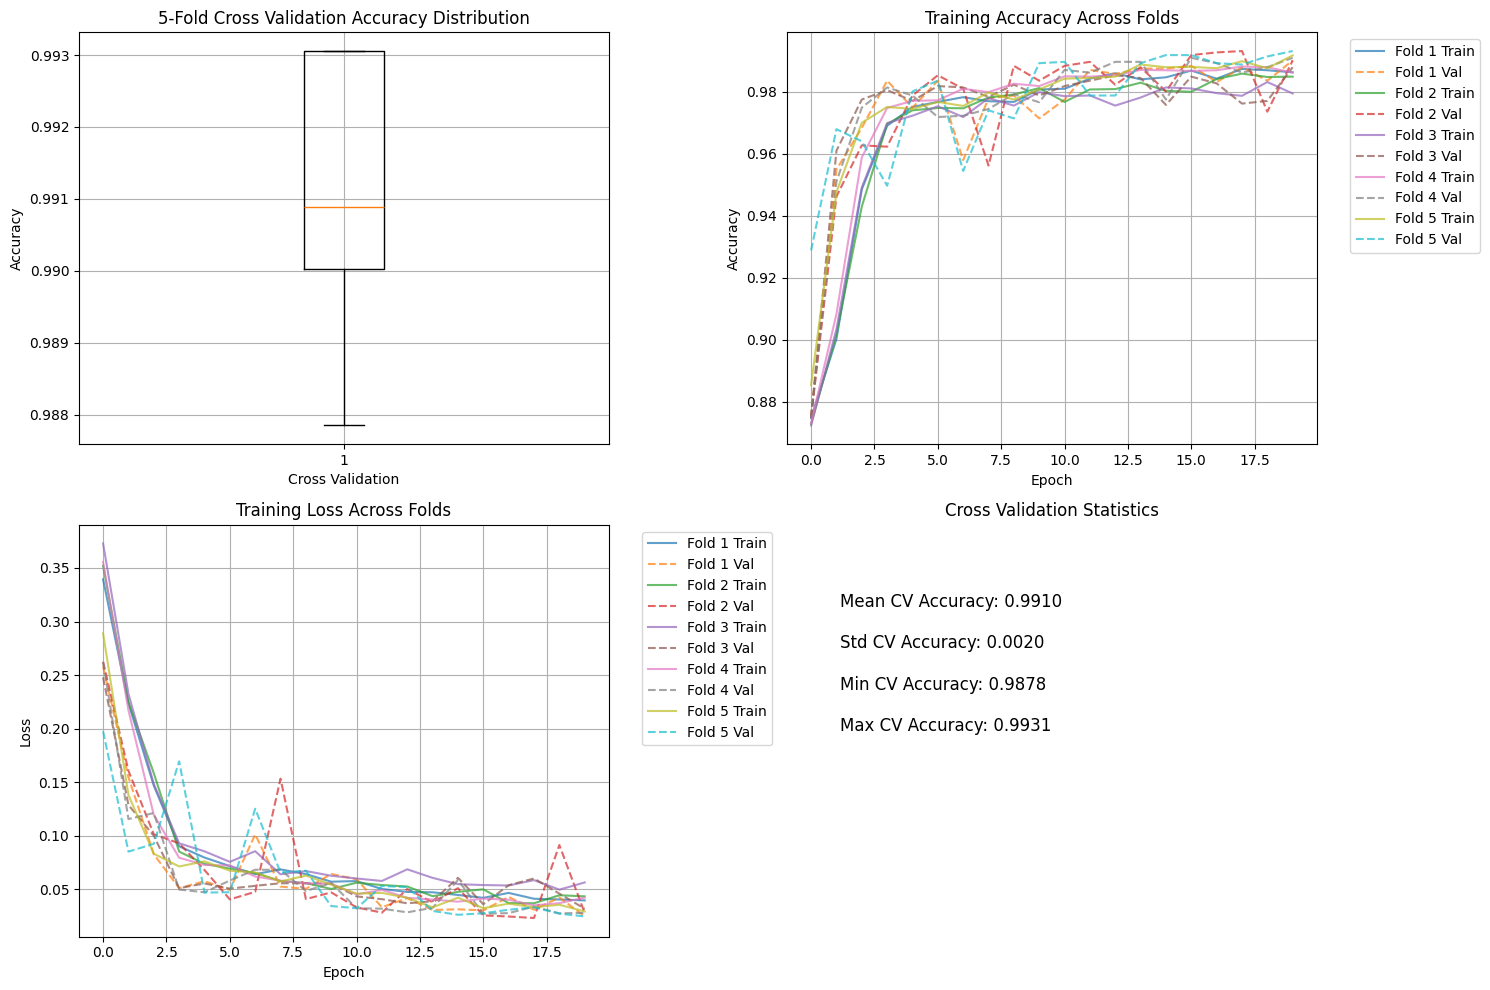

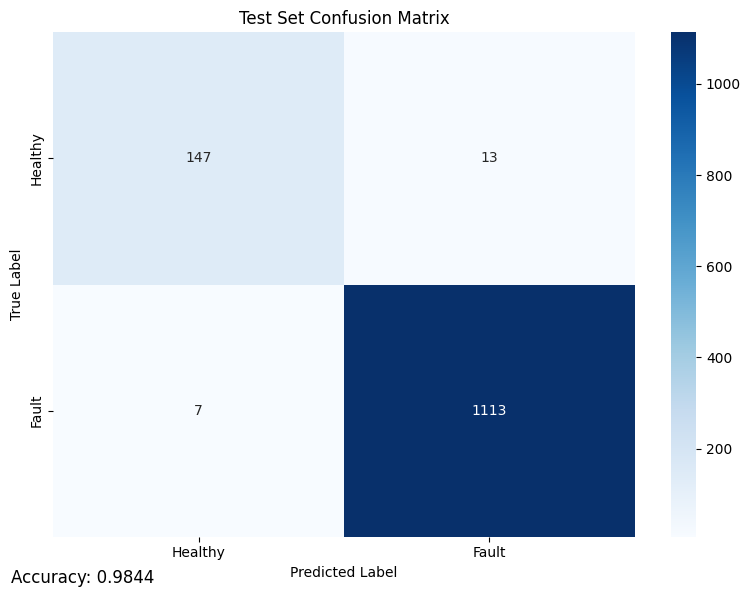

              precision    recall  f1-score   support

     Healthy       0.95      0.92      0.94       160
       Fault       0.99      0.99      0.99      1120

    accuracy                           0.98      1280
   macro avg       0.97      0.96      0.96      1280
weighted avg       0.98      0.98      0.98      1280

Keras 3 模型已保存為 'best_shallow_cnn_model.keras'

=== 轉換為 TensorFlow Lite 模型 ===
INFO:tensorflow:Assets written to: /var/folders/bg/8cbnf2jj4237_mg6pkq__cph0000gn/T/tmpwm2caskn/assets


INFO:tensorflow:Assets written to: /var/folders/bg/8cbnf2jj4237_mg6pkq__cph0000gn/T/tmpwm2caskn/assets


Saved artifact at '/var/folders/bg/8cbnf2jj4237_mg6pkq__cph0000gn/T/tmpwm2caskn'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 64, 64, 1), dtype=tf.float32, name='input_layer_15')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  13147976720: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13147977488: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13147978832: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13147979216: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13147967120: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13107685776: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13107685392: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13107690576: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13107686736: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13107684624: TensorSpec(shape=(), dtype=tf.resource, name=None)
TFLite 模型已保存

W0000 00:00:1751658761.358547 48308983 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1751658761.358559 48308983 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
2025-07-05 03:52:41.358712: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /var/folders/bg/8cbnf2jj4237_mg6pkq__cph0000gn/T/tmpwm2caskn
2025-07-05 03:52:41.359234: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2025-07-05 03:52:41.359241: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /var/folders/bg/8cbnf2jj4237_mg6pkq__cph0000gn/T/tmpwm2caskn
2025-07-05 03:52:41.364406: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2025-07-05 03:52:41.392376: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: /var/folders/bg/8cbnf2jj4237_mg6pkq__cph0000gn/T/tmpwm2caskn
2025-07-05 03:52:41.401559: I tensorflow/cc/saved_model/loader.c

In [11]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import os

# 函數 create_shallow_cnn, plot_cv_results, plot_confusion_matrix 保持不變
def create_shallow_cnn(input_shape=(64, 64, 1)):
    """使用Functional API建立CNN模型"""
    inputs = tf.keras.Input(shape=input_shape)
    
    x = layers.Conv2D(8, (3, 3), activation='relu')(inputs)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(16, (3, 3), activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(16, (3, 3), activation='relu')(x)
    x = layers.Flatten()(x)
    x = layers.Dense(16, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)
    
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model


def plot_cv_results(cv_scores, cv_histories):
    """
    繪製交叉驗證結果
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # 交叉驗證準確率分布
    axes[0, 0].boxplot(cv_scores)
    axes[0, 0].set_title('5-Fold Cross Validation Accuracy Distribution')
    axes[0, 0].set_ylabel('Accuracy')
    axes[0, 0].set_xlabel('Cross Validation')
    axes[0, 0].grid(True)
    
    # 各fold的準確率曲線
    for i, history in enumerate(cv_histories):
        axes[0, 1].plot(history.history['accuracy'], label=f'Fold {i+1} Train', alpha=0.7)
        axes[0, 1].plot(history.history['val_accuracy'], label=f'Fold {i+1} Val', alpha=0.7, linestyle='--')
    axes[0, 1].set_title('Training Accuracy Across Folds')
    axes[0, 1].set_ylabel('Accuracy')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    axes[0, 1].grid(True)
    
    # 各fold的損失曲線
    for i, history in enumerate(cv_histories):
        axes[1, 0].plot(history.history['loss'], label=f'Fold {i+1} Train', alpha=0.7)
        axes[1, 0].plot(history.history['val_loss'], label=f'Fold {i+1} Val', alpha=0.7, linestyle='--')
    axes[1, 0].set_title('Training Loss Across Folds')
    axes[1, 0].set_ylabel('Loss')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    axes[1, 0].grid(True)
    
    # 交叉驗證統計結果
    axes[1, 1].text(0.1, 0.8, f'Mean CV Accuracy: {np.mean(cv_scores):.4f}', fontsize=12, transform=axes[1, 1].transAxes)
    axes[1, 1].text(0.1, 0.7, f'Std CV Accuracy: {np.std(cv_scores):.4f}', fontsize=12, transform=axes[1, 1].transAxes)
    axes[1, 1].text(0.1, 0.6, f'Min CV Accuracy: {np.min(cv_scores):.4f}', fontsize=12, transform=axes[1, 1].transAxes)
    axes[1, 1].text(0.1, 0.5, f'Max CV Accuracy: {np.max(cv_scores):.4f}', fontsize=12, transform=axes[1, 1].transAxes)
    axes[1, 1].set_title('Cross Validation Statistics')
    axes[1, 1].axis('off')
    
    plt.tight_layout()
    plt.savefig('cross_validation_results.png', dpi=300, bbox_inches='tight')
    plt.show()

def plot_confusion_matrix(y_true, y_pred, title='Confusion Matrix'):
    """
    繪製混淆矩陣
    """
    # 計算混淆矩陣
    cm = confusion_matrix(y_true, y_pred)
    
    # 創建圖表
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Healthy', 'Fault'], 
                yticklabels=['Healthy', 'Fault'])
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    
    # 添加統計信息
    accuracy = np.trace(cm) / np.sum(cm)
    plt.figtext(0.02, 0.02, f'Accuracy: {accuracy:.4f}', fontsize=12)
    
    plt.tight_layout()
    plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return cm


def train_with_cross_validation():
    """
    使用5-fold交叉驗證訓練模型，並在測試集上評估
    """
    # 載入數據和預處理...
    try:
        print("載入 STFT 處理後的數據...")
        X_cv = np.load('X_cv_stft.npy')
        X_test = np.load('X_test_stft.npy')
        y_cv = np.load('y_cv.npy')
        y_test = np.load('y_test.npy')
    except FileNotFoundError as e:
        print("錯誤：找不到數據檔案！")
        return None, None
    
    X_cv = np.expand_dims(X_cv, axis=-1)
    X_test = np.expand_dims(X_test, axis=-1)
    X_cv_min, X_cv_max = np.min(X_cv), np.max(X_cv)
    X_test_min, X_test_max = np.min(X_test), np.max(X_test)
    X_cv = (X_cv - X_cv_min) / (X_cv_max - X_cv_min)
    X_test = (X_test - X_test_min) / (X_test_max - X_test_min)

    norm_params = {
    'min': X_cv_min,
    'max': X_cv_max
    }
    
    np.save('normalization_params.npy', norm_params)
    
    print(f"✅ 正規化參數已成功保存至 'normalization_params.npy'")
    print(f"   Min: {norm_params['min']:.4f}")
    print(f"   Max: {norm_params['max']:.4f}")

    # 交叉驗證 #############################
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores, cv_histories, fold_models = [], [], []
    
    print("\n開始5-fold交叉驗證...")
    
    for fold, (train_idx, val_idx) in enumerate(kfold.split(X_cv, y_cv)):
        print(f"\n=== Fold {fold + 1}/5 ===")
        X_train_fold, y_train_fold = X_cv[train_idx], y_cv[train_idx]
        X_val_fold, y_val_fold = X_cv[val_idx], y_cv[val_idx]
        
        model = create_shallow_cnn()
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
        
        callbacks = [
            tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=0),
            tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-7, verbose=0)
        ]
        ################################
        history = model.fit(X_train_fold, y_train_fold, epochs=20, batch_size=32, validation_data=(X_val_fold, y_val_fold), callbacks=callbacks, verbose=1)
        
        val_loss, val_acc = model.evaluate(X_val_fold, y_val_fold, verbose=0)
        cv_scores.append(val_acc)
        cv_histories.append(history)
        fold_models.append(model)
        
        print(f"Fold {fold + 1} 驗證準確率: {val_acc:.4f}")
    
    # 選擇最佳模型
    best_fold_idx = np.argmax(cv_scores)
    best_model = fold_models[best_fold_idx]
    
    print(f"\n選擇Fold {best_fold_idx + 1}的模型作為最佳模型（驗證準確率: {cv_scores[best_fold_idx]:.4f}）")
    best_model.summary()
    
    # 測試集評估
    test_loss, test_acc = best_model.evaluate(X_test, y_test, verbose=0)
    print(f"\n測試集準確率: {test_acc:.4f}")
    
    y_test_pred_prob = best_model.predict(X_test, verbose=0)
    y_test_pred = (y_test_pred_prob > 0.5).astype(int).flatten()
    
    plot_cv_results(cv_scores, cv_histories)
    plot_confusion_matrix(y_test, y_test_pred, 'Test Set Confusion Matrix')
    
    print(classification_report(y_test, y_test_pred, target_names=['Healthy', 'Fault']))
    
    # ===== 1. 修改 TFLite 轉換流程以適應 Keras 3 =====
    # 首先，將模型保存為 Keras 3 的原生 .keras 格式
    keras_model_path = 'best_shallow_cnn_model.keras'
    best_model.save(keras_model_path)
    print(f"Keras 3 模型已保存為 '{keras_model_path}'")
    
    # 然後，從 .keras 檔案重新載入模型。這一步驟有助於 TFLite 轉換器正確解析模型。
    loaded_model = tf.keras.models.load_model(keras_model_path)

    print("\n=== 轉換為 TensorFlow Lite 模型 ===")
    # 使用重新載入的模型進行轉換
    converter = tf.lite.TFLiteConverter.from_keras_model(loaded_model)
    # ===============================================

    # 添加量化優化
    converter.optimizations = [tf.lite.Optimize.DEFAULT]
    
    # 轉換模型
    tflite_model = converter.convert()
    
    # 保存 tflite 檔案
    tflite_model_path = 'best_shallow_cnn_model.tflite'
    with open(tflite_model_path, 'wb') as f:
        f.write(tflite_model)
    
    print(f"TFLite 模型已保存為 '{tflite_model_path}'")
    print(f"TFLite 模型大小: {len(tflite_model) / 1024:.2f} KB")

    # ... (後續保存數據和結果的代碼) ...
    
    return best_model, None

# 執行訓練
if __name__ == "__main__":
    print("開始 CNN 模型訓練...")
    print(f"TensorFlow 版本: {tf.__version__}")
    print(f"Keras 版本: {tf.keras.__version__}")
    print("基於 STFT 特徵的馬達故障診斷")
    print(f"{'='*50}")
    
    train_with_cross_validation()
    
    print(f"\n{'='*50}")
    print("訓練完成！")



### TFLite 性能評估 與 特定 Index 比較

In [12]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# 1. 載入 TFLite 模型
interpreter = tf.lite.Interpreter(model_path="best_shallow_cnn_model.tflite")
interpreter.allocate_tensors()

# 2. 取得模型的輸入/輸出資訊
input_details = interpreter.get_input_details()[0]
output_details = interpreter.get_output_details()[0]

# 3. 載入測試集
X_test = np.load('X_test_stft.npy')    # shape: (N, 64, 64)
y_test = np.load('y_test.npy')    # shape: (N,)

# 4. 根據模型需求調整 shape
if len(X_test.shape) == 3:
    X_test = np.expand_dims(X_test, axis=-1)  # 變成 (N, 64, 64, 1)

# 5. 正規化（依照訓練時的方式）
X_test = (X_test - (-115.0041)) / (3.395 - (-115.0041))

# 6. 測試指定 sample index
sample_index = 500
input_data = X_test[sample_index:sample_index+1].astype(np.float32)

# 設置輸入張量
interpreter.set_tensor(input_details['index'], input_data)

# 執行推論
interpreter.invoke()

# 獲取輸出結果
output_data = interpreter.get_tensor(output_details['index'])
confidence_score = output_data[0][0]  # sigmoid 輸出值

# 真實標籤
true_label = "Healthy" if y_test[sample_index] == 0 else "Fault"

# 輸出詳細結果
print("="*60)
print(f"特別測試樣本索引: {sample_index}")
print(f"真實標籤: {true_label}")
print(f"模型信心分數: {confidence_score:.6f}")
print(f"預測結果: {'FAULT' if confidence_score > 0.5 else 'HEALTHY'}")
print("="*60)

# 7. 批量推論整個測試集
y_pred = []
for i in range(len(X_test)):
    input_data = X_test[i:i+1].astype(np.float32)
    interpreter.set_tensor(input_details['index'], input_data)
    interpreter.invoke()
    output_data = interpreter.get_tensor(output_details['index'])
    y_pred.append(output_data[0][0])

# 8. 根據 0.5 閥值進行二元分類
y_pred_label = (np.array(y_pred) > 0.5).astype(int)

# 9. 計算準確率與報告
acc = accuracy_score(y_test, y_pred_label)
print(f"\nTFLite模型在測試集上的準確率: {acc:.4f}")
print("混淆矩陣：")
print(confusion_matrix(y_test, y_pred_label))
print("分類報告：")
print(classification_report(y_test, y_pred_label, target_names=['Healthy', 'Fault']))

# 10. 輸出索引 515 的原始數據（可選，用於比對 MCU 輸入）
print("\n索引 515 的原始數據摘要：")
print(f"數據形狀: {X_test[sample_index].shape}")
print(f"最小值: {np.min(X_test[sample_index]):.4f}")
print(f"最大值: {np.max(X_test[sample_index]):.4f}")
print(f"平均值: {np.mean(X_test[sample_index]):.4f}")
print(f"前 5 個值: {X_test[sample_index].flatten()[:5]}")


特別測試樣本索引: 500
真實標籤: Healthy
模型信心分數: 0.000015
預測結果: HEALTHY

TFLite模型在測試集上的準確率: 0.9883
混淆矩陣：
[[ 153    7]
 [   8 1112]]
分類報告：
              precision    recall  f1-score   support

     Healthy       0.95      0.96      0.95       160
       Fault       0.99      0.99      0.99      1120

    accuracy                           0.99      1280
   macro avg       0.97      0.97      0.97      1280
weighted avg       0.99      0.99      0.99      1280


索引 515 的原始數據摘要：
數據形狀: (64, 64, 1)
最小值: 0.2468
最大值: 0.7158
平均值: 0.5048
前 5 個值: [0.33962712 0.54784348 0.60058268 0.62709638 0.64017538]


/opt/anaconda3/lib/python3.12/site-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


### 隨機抽取100筆測試集資料

In [ ]:
import numpy as np

# 載入現有的 npy 檔案
X_test_final = np.load('x_test_final.npy')
y_test_final = np.load('y_test_final.npy')

# 隨機抽取100個樣本的索引（固定隨機種子以利重現）
np.random.seed(42)
total_samples = X_test_final.shape[0]
selected_indices = np.random.choice(total_samples, 10, replace=False)

# 取出對應的資料
X_test_small = X_test_final[selected_indices]
y_test_small = y_test_final[selected_indices]

# 儲存為新的 npy 檔案
np.save('X_test_small.npy', X_test_small)
np.save('y_test_small.npy', y_test_small)


### 查看.npy

In [ ]:
import numpy as np

# 載入 .npy 檔案
file_path = 'x_test_final.npy'  # 請替換成實際檔名
data = np.load(file_path)

# 顯示 shape、資料型態
print(f"檔案名稱：{file_path}")
print(f"資料型態：{type(data)}")
print(f"陣列形狀：{data.shape}")
print(f"資料 dtype：{data.dtype}")

# 顯示前5筆資料
print("\n前5筆資料內容：")
print(data[:1])

# 若是多維陣列，可顯示每一維的統計
if np.issubdtype(data.dtype, np.number):
    print("\n數值統計：")
    print(f"最小值：{np.min(data)}")
    print(f"最大值：{np.max(data)}")
    print(f"平均值：{np.mean(data)}")
    print(f"標準差：{np.std(data)}")
